# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! ls ../eos/Apr12_presel_2017/

DYJetsToLL_M-10to50                     SingleElectron_Run2017E
DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to32

In [24]:
! ls ../combine/hww_templates

cat1_sr.root


In [38]:
import uproot
f = uproot.open("../combine/hww_templates/cat1_sr.root")
f.keys()

['cat1_sr;1',
 'cat1_sr/WJetsLNu;1',
 'cat1_sr/TTbar;1',
 'cat1_sr/HWW;1',
 'cat1_sr/data_obs;1',
 'cat1_sr/QCD;1']

In [39]:
f["cat1_sr/HWW"].to_hist()

Hist(Regular(35, 0, 480, name='rec_higgs_m', label='Higgs reconstructed mass [GeV]'), storage=Double()) # Sum: 399.61459880717103 (400.33371576297384 with flow)

In [43]:
f["cat1_sr/WJetsLNu"].to_hist()

Hist(Regular(35, 0, 480, name='rec_higgs_m', label='Higgs reconstructed mass [GeV]'), storage=Double()) # Sum: 135314.24218196032 (136449.5504403251 with flow)

In [4]:
presel = {
    "mu": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        
        ### signal region
        "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",      

        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",        
    },
    "ele": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",

        ### signal region
        "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top control region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",     
        
        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",
        
    }    
}

weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

In [14]:
years = ["2017", "2016", "2016APV", "2018"]
channels = ["mu", "ele"]

samples_dir = f"../eos/Apr12_presel_"
# samples_dir = f"../eos/Jul15_region_wjets_"
# samples_dir = f"../eos/Jul12QCD_"

samples = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
#     "DYJets",
    "WJetsLNu",
#     "WZQQ",
    "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

In [15]:
from make_hists import make_events_dict
events_dict = make_events_dict(years, channels, samples_dir, samples, presel, weights, "all", add_tagger_score=True)

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
1.0949416558557916
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 37101 events
applying tagger selection on 4443 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 131 events
tot event weight 212.46127711555283 

Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.04037521924527721
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weig

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Accumulating event weights.
0.015609081084482931
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 2521 events
applying tagger selection on 1477 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 78 events
tot event weight 1.13473992139099 

Finding QCD_Pt_600to800 samples and should combine them under QCD
---> Accumulating event weights.
0.3245439095
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_tr

---> Accumulating event weights.
0.0003367024440993835
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 1145640 events
applying tagger selection on 869405 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 30554 events
tot event weight 2768.2014583311784 

Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.009666731596105928
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done w

---> Accumulating event weights.
0.08219963287816091
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 243360 events
applying tagger selection on 128984 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 23670 events
tot event weight 2578.0878642547586 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.0009182309549050811
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating

---> Accumulating event weights.
0.000407111312769749
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 316509 events
applying tagger selection on 256502 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 6224 events
tot event weight 172.03383635065126 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
3.134147809540762e-05
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_n

---> Accumulating event weights.
1.0654102798031664
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 11547 events
applying tagger selection on 1148 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 23 events
tot event weight 34.428303547094636 

Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.03892997488073508
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event we

---> Accumulating event weights.
2.0834458052655185
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 11405 events
applying tagger selection on 4746 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 265 events
tot event weight 538.2680494553088 

Finding QCD_Pt_170to300 samples and should combine them under QCD
---> Accumulating event weights.
59.0533860566153
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulati

applying tagger selection on 53153 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 6593 events
tot event weight 3514.9826790995835 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Accumulating event weights.
0.015385380036836687
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 10314 events
applying tagger selection on 9626 events
---> Done with preselection.
Will fill the HWW dataframe with the remaining 4838 events
tot event weight 33.094997431069345 

Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> Accumulating event weights.
2.62971

---> Applying preselection.
applying lep_fj_dr selection on 122036 events
applying tagger selection on 74677 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 14465 events
tot event weight 1864.052446966748 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.0006309278809471105
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 71327 events
applying tagger selection on 53586 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 4401 events
tot event weight 3.398694723992388 

Finding QCD_Pt_800to1000 samples and should 

---> Accumulating event weights.
0.0005491480458960981
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 321220 events
applying tagger selection on 240646 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 5507 events
tot event weight 186.89598898671443 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
3.403913792597533e-05
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Don

---> Accumulating event weights.
0.040404566496860805
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 472782 events
applying tagger selection on 313650 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 67013 events
tot event weight 3888.1275664132304 

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Accumulating event weights.
0.0004848959947093383
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Appl

---> Accumulating event weights.
0.467793837
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 2227 events
applying tagger selection on 1228 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 59 events
tot event weight 27.27374361632597 

Finding QCD_Pt_300to470 samples and should combine them under QCD
---> Accumulating event weights.
20.31480544665461
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_t

---> Applying preselection.
applying lep_fj_dr selection on 1126161 events
applying tagger selection on 865290 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 31091 events
tot event weight 4187.010615798778 

Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.010659192129066063
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 407682 events
applying tagger selection on 262826 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 38649 events
tot event weight 539.5308037693394 

Finding WJetsToLNu_HT-200To400 samples and should combine them und

---> Accumulating event weights.
0.08516652180756897
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 341721 events
applying tagger selection on 183963 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 33617 events
tot event weight 3918.478739763413 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.0007496476752546608
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal wei

In [16]:
events_dict.keys()

dict_keys(['2017', '2016', '2016APV', '2018'])

In [17]:
events_dict["2017"].keys()

dict_keys(['mu', 'ele'])

In [18]:
events_dict["2017"]["mu"].keys()

dict_keys(['WJetsLNu', 'TTbar', 'HWW', 'QCD'])

In [19]:
events_dict["2017"]["mu"]["WJetsLNu"]

,fj_pt,fj_msoftdrop,fj_msoftdrop_nocorr,fj_mass,fj_lsf3,fj_sj1_pt,fj_sj2_pt,fj_tau3,fj_tau2,fj_bjets_ophem,...,fj_ParT_probTopbWqq1c,fj_ParT_probTopbWq0c,fj_ParT_probTopbWq1c,fj_ParT_probTopbWev,fj_ParT_probTopbWmv,fj_ParT_probTopbWtauhv,fj_ParT_probTopbWtauev,fj_ParT_probTopbWtaumv,event_weight,inclusive_score
449,216.500,85.618997,87.00000,87.5000,0.911621,163.500,53.03125,0.058350,0.100952,NaN,...,0.000006,0.000021,1.229289e-06,6.708831e-05,0.049023,0.000662,1.283468e-05,0.001699,1.731484,0.943297
506,216.125,83.214579,83.12500,85.5000,0.875000,133.875,85.43750,0.083984,0.168945,NaN,...,0.000003,0.000001,1.463522e-07,1.726276e-06,0.012211,0.000004,3.773895e-07,0.000460,1.573169,0.987277
644,235.125,66.159748,69.43750,79.0625,0.958496,144.750,86.81250,0.040131,0.067566,0.005802,...,0.000002,0.000006,3.206220e-07,1.521172e-06,0.019914,0.000005,2.769655e-07,0.000625,1.694781,0.979308
724,201.250,79.888402,81.06250,82.0000,0.767090,111.375,97.75000,0.131348,0.192139,0.029602,...,0.000017,0.000001,3.088304e-07,4.657925e-07,0.016222,0.000006,2.833833e-07,0.001642,1.620218,0.982091
813,275.000,110.645918,105.93750,107.3750,0.979980,166.625,105.31250,0.041077,0.063293,0.034180,...,0.000005,0.000012,1.214570e-06,2.458401e-05,0.073372,0.000188,3.547277e-06,0.002540,1.435127,0.915355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204356,222.125,85.843097,86.00000,87.3125,0.964355,151.500,68.50000,0.135376,0.171631,0.035583,...,0.000007,0.000019,1.031675e-06,9.370752e-06,0.074733,0.000022,1.944456e-06,0.004599,0.503307,0.920235
204368,242.625,71.625571,74.43750,82.5000,0.770508,141.625,94.43750,0.079407,0.098572,0.045105,...,0.000664,0.021415,5.828874e-04,6.259193e-05,0.002584,0.001213,4.040022e-05,0.000629,0.292493,0.962254
204378,290.500,61.529557,63.53125,67.9375,0.942383,211.000,72.75000,0.050903,0.091187,0.195312,...,0.000006,0.000003,1.095025e-07,1.239053e-06,0.032231,0.000003,2.247266e-07,0.001041,0.519066,0.966616
204379,225.000,78.209688,78.75000,79.1250,0.871094,177.250,53.62500,0.074463,0.135010,0.190063,...,0.000010,0.000009,6.545471e-07,6.755321e-07,0.025688,0.000003,2.465976e-07,0.001259,0.275015,0.972942


In [20]:
events_dict["2017"]["mu"]["WJetsLNu"]["fj_minus_lep_m"]

# plot dR when there is value vs when there is NaN

449       41.540497
506       51.357632
644       37.173199
724       59.138203
813       44.364216
            ...    
204356    55.665619
204368    51.188297
204378    44.937107
204379    55.994141
204387    33.748726
Name: fj_minus_lep_m, Length: 179927, dtype: float32

In [ ]:
plt.rcParams.update({"font.size": 20})

sample = "QCD"
var = "rec_higgs_m"

# make histogram
h = hist2.Hist(
   utils.axis_dict[var]
)    

for sample in samples:
    for year in years:
        for ch in channels:

            df = events_dict[year][ch][sample]

            h.fill(
                var=df[var],
                weight=df["event_weight"]
            )

# plot histogram
fig, ax = plt.subplots(figsize=(7, 5))

for samples 
hep.histplot(
    h1,
    ax=ax,
    label="Signal region",
    linewidth=3,
    density=True
)

ax.legend(title=sample)
ax.set_ylabel("Events");  

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    

hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig("/Users/fmokhtar/Desktop/hww/rec_higgs_m_qcd")        

# Plot histograms

In [42]:
plt.rcParams.update({"font.size": 20})

sample = "QCD"
var = "rec_higgs_m"

# make histogram
h1 = hist2.Hist(
   utils.axis_dict[var]
)    

for year in years:
    for ch in channels:

        df = events_dict[year][ch][sample]

        h1.fill(
            var=df[var],
            weight=df["event_weight"]
        )

In [47]:
plt.rcParams.update({"font.size": 20})

sample = "QCD"
var = "rec_higgs_m"

# make histogram
h2 = hist2.Hist(
   utils.axis_dict[var]
)    

for year in years:
    for ch in channels:

        df = events_dict[year][ch][sample]

        h2.fill(
            var=df[var],
            weight=df["event_weight"]
        )

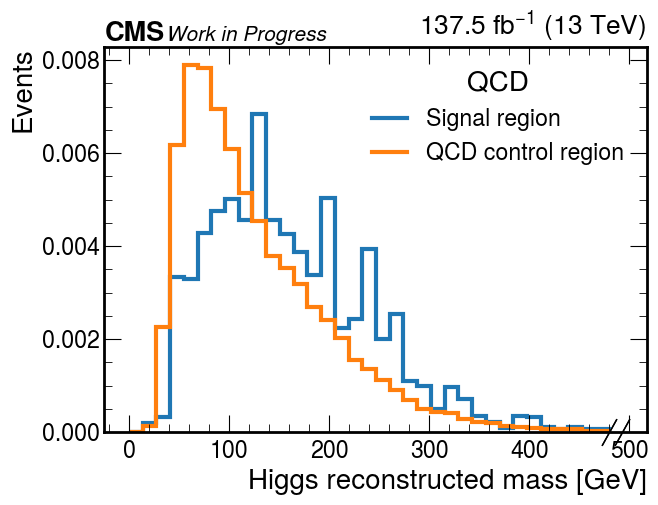

In [48]:
# plot histogram
fig, ax = plt.subplots(figsize=(7, 5))

hep.histplot(
    h1,
    ax=ax,
    label="Signal region",
    linewidth=3,
    density=True
)
hep.histplot(
    h2,
    ax=ax,
    label="QCD control region",
    linewidth=3,
    density=True
)
ax.legend(title=sample)
ax.set_ylabel("Events");  

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    

hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig("/Users/fmokhtar/Desktop/hww/rec_higgs_m_qcd")

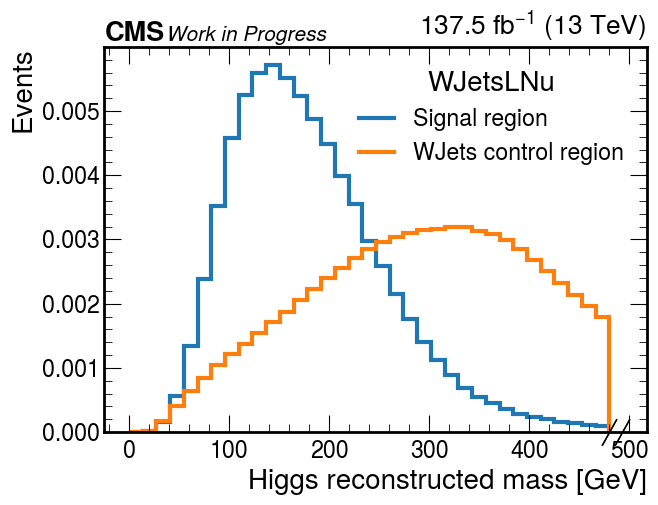

In [33]:
# plot histogram
fig, ax = plt.subplots(figsize=(7, 5))

hep.histplot(
    h1,
    ax=ax,
    label="Signal region",
    linewidth=3,
    density=True
)
hep.histplot(
    h2,
    ax=ax,
    label="WJets control region",
    linewidth=3,
    density=True
)
ax.legend(title=sample)
ax.set_ylabel("Events");  

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    

hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig("/Users/fmokhtar/Desktop/hww/rec_higgs_m_wjets")

## 1d-hists

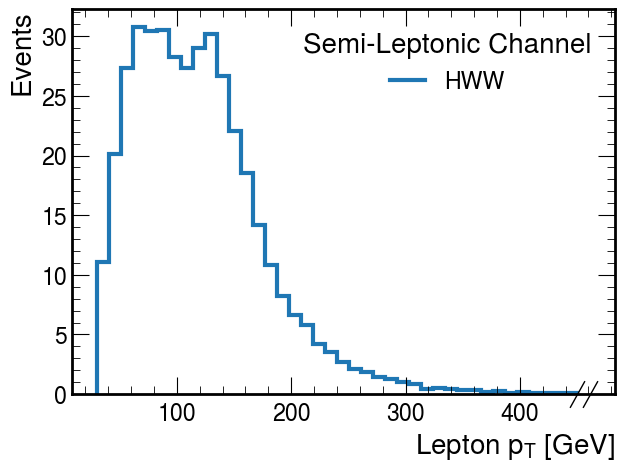

In [11]:
plt.rcParams.update({"font.size": 20})

sample = "HWW"

# make histogram
h = hist2.Hist(
    hist2.axis.Regular(40, 30, 450, name="var", label=r"Lepton $p_T$ [GeV]", overflow=True),
)    

for year in years:
    for ch in channels:

        df = events_dict[year][ch][sample]

        h.fill(
            var=df["lep_pt"],
            weight=df["event_weight"]
        )

# plot histogram
fig, ax = plt.subplots(figsize=(7, 5))

hep.histplot(
    h,
    ax=ax,
    label=sample,
    linewidth=3,
#     density=True
)

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

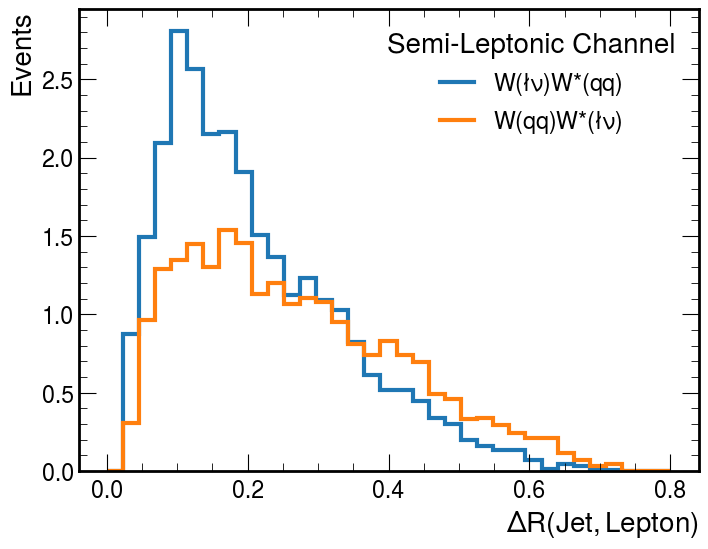

In [11]:
# make histogram
h = hist2.Hist(
    hist2.axis.Regular(35, 0.0, 0.8, name="var", label=r"$\Delta R(Jet, Lepton)$", overflow=True),
    hist2.axis.Boolean(name="from_W")        
)

for year in years:
    for ch in channels:
        
        h.fill(
            var=events_dict[year][ch]["HWW"]["lep_fj_dr"],
            from_W=events_dict[year][ch]["HWW"]["fj_H_VV_isVlepton"]==True,
            weight=events_dict[year][ch]["HWW"]["event_weight"]
        )

# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))

hep.histplot(
    h[{"from_W": 1}],
    ax=ax,
    label=r"W($\l\nu$)W*(qq)",
    linewidth=3,
#     density=True
)
hep.histplot(
    h[{"from_W": 0}],
    ax=ax,
    label=r"W(qq)W*($\l\nu$)",
    linewidth=3,
#     density=True    
)
     
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");

# Stacked hists

In [12]:
vars_to_plot = [
#     "fj_minus_lep_m",
#     "fj_pt",
    "lep_pt",
#     "fj_msoftdrop",
#     "fj_bjets_ophem",
#     "fj_bjets",
#     "lep_fj_dr",
#     "lep_met_mt",
#     "ht",
#     "met_fj_dphi",
#     "deta",
#     "met",
#     "mjj",
#     "fj_pt_over_lep_pt",
#     "rec_higgs_m",
#     "rec_higgs_pt",
#     "rec_higgs_pt_over_lep_pt",    
#     "golden_var",
#     "rec_dphi_WW",
#     "fj_ParT_mass",
#     "fj_ParticleNet_mass"
#     "nj",
#     "inclusive_score"
]

samples_to_plot = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

In [13]:
channels = ["ele", "mu"]

# fill histograms
hists = {}
for var in vars_to_plot:
            
    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
#         hist2.axis.Regular(25, 0.0, 2.5, name="var", label=r"$\Delta R(Jet, Lepton)$", overflow=True)
    )
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
                df = events_dict[year][ch][sample]

    #             df = df[df["fj_pt"]>650]
    #             df = df[df["fj_pt"]<650]            

    #             # tagger cut
    #             df = df[df["inclusive_score"] > 0.99]

    #             df = df[df["fj_minus_lep_m"]>70]
    #             df = df[df["lep_fj_dr"]>0.5]

                # lep and jet overlap cut
    #             df = df[df["fj_pt"]/df["lep_pt"]>1.6]            
    #             df = df[df["lep_fj_dr"]>0.01]

    #             # WJetsLNu control region
    #             df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<2]

    #             # TTbar control region
    #             df = df[df["n_bjets_M"]<2]

    #             df = df[df["met"]<100]

                if var=="golden_var":
                    hists[var].fill(
                        samples=sample,
                        var=df["rec_W_lnu_pt"]/df["rec_W_qq_pt"],
                        weight=df["event_weight"]
                    )                 
                elif var == "fj_pt_over_lep_pt":
                    hists[var].fill(
                        samples=sample,
                        var=df["fj_pt"]/df["lep_pt"],
                        weight=df["event_weight"]
                    )
                elif var=="rec_higgs_pt_over_lep_pt":
                    hists[var].fill(
                        samples=sample,
                        var=df["rec_higgs_pt"]/df["lep_pt"],
                        weight=df["event_weight"]
                    )                
                elif var=="rec_dphi_WW":
                    hists[var].fill(
                        samples=sample,
                        var=np.abs(df["rec_dphi_WW"]),
                        weight=df["event_weight"]
                    )     
                elif var=="fj_msoftdrop+met":
                    hists[var].fill(
                        samples=sample,
                        var=df["fj_msoftdrop"]+df["met"],
                        weight=df["event_weight"]
                    )   
                elif var=="fj_ParT_mass-met":
                    hists[var].fill(
                        samples=sample,
                        var=df["fj_ParT_mass"]-df["met"],
                        weight=df["event_weight"]
                    )  
                elif var=="met_fj_dphi":
                    hists[var].fill(
                        samples=sample,
                        var=np.abs(df["met_fj_dphi"]),
                        weight=df["event_weight"]
                    )                  
                else:
                    hists[var].fill(
                        samples=sample,
                        var=df[var],
                        weight=df["event_weight"]
                    )

Will plot lep_pt histogram


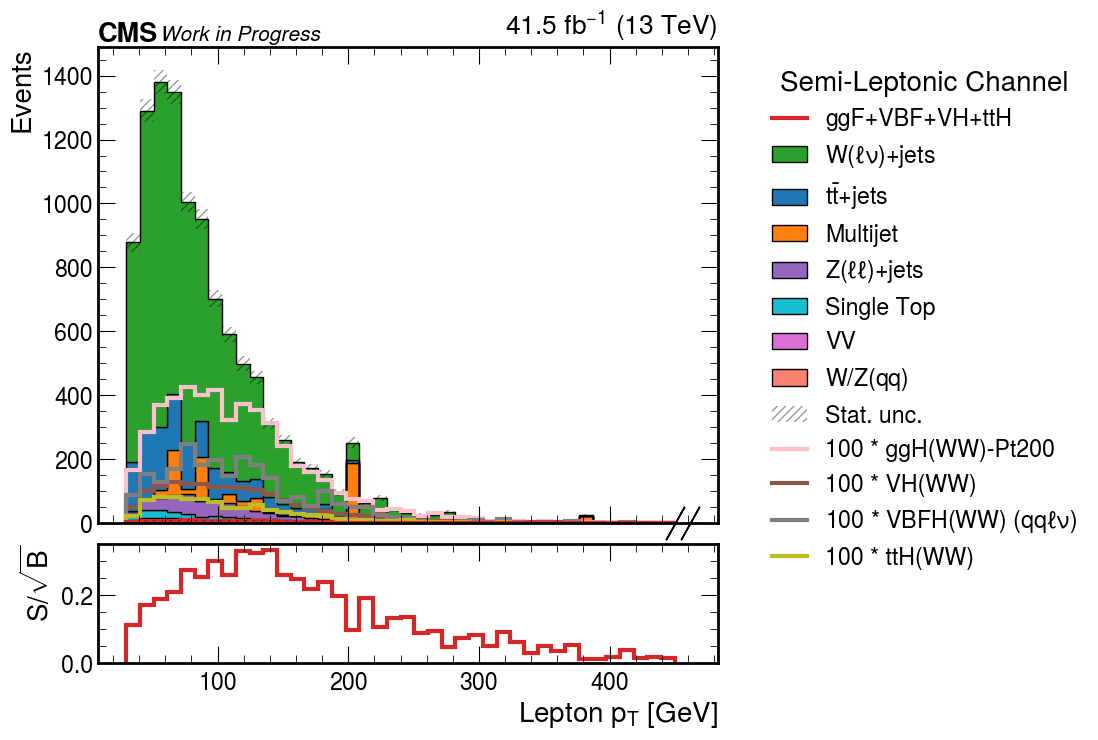

In [14]:
plt.rcParams.update({"font.size": 20})
from utils import plot_hists
plot_hists(years, channels, hists, vars_to_plot,             
            add_data=False,
            logy=False,
            add_soverb=True,
            only_sig=False,
            mult=100,
            outpath="/Users/fmokhtar/Desktop/farakiko/")

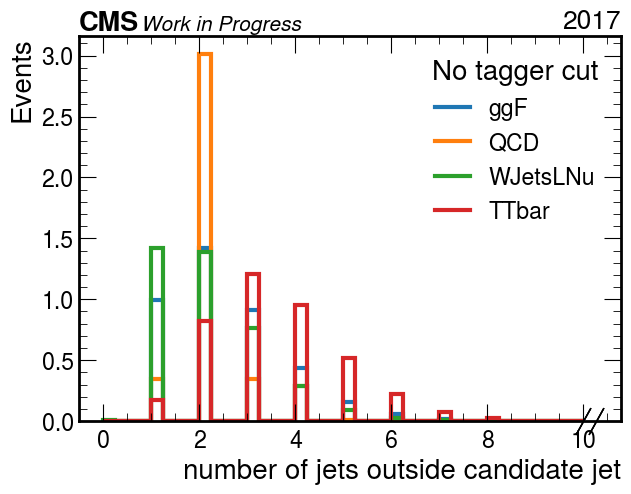

In [20]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
     "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "nj"
# var = "met_fj_dphi"
# var = "lep_met_mt"
# var = "mjj"


h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(7, 5))

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            df = events_dict[year][ch][sample]

            # tagger cut
    #         df = df[df["inclusive_score"]>0.9]

    #         df = df[df["lep_fj_dr"]>0.03]        
            df = df[df["n_bjets_M"]<2]
    #         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

            h.fill(
                samples=sample,
                var=df[var],
                weight=df["event_weight"]
            )

for sample in samples_to_plot:
    if sample in utils.sig_labels:
        lab = utils.sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"No tagger cut")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

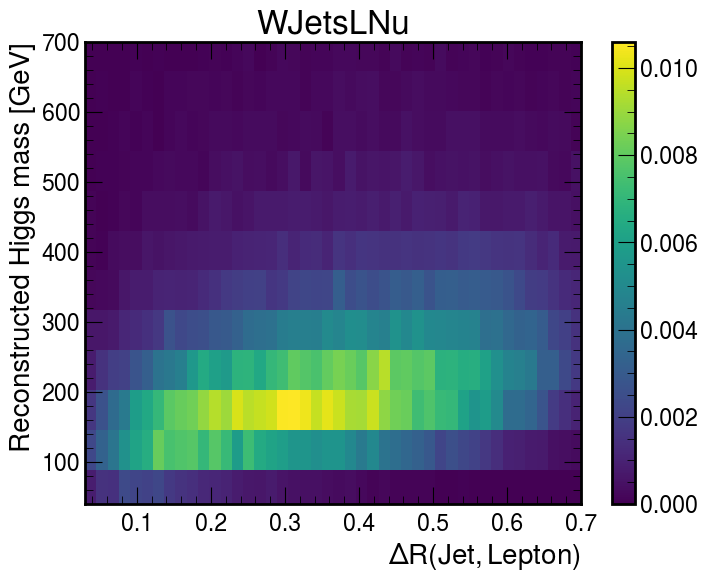

In [16]:
samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

var1 = "lep_fj_dr"
var2 = "rec_higgs_m"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))

for sample in samples_to_plot:
    for year in years:
        for i, ch in enumerate(channels):
            df = events_dict[year][ch][sample]

            df = df[df["inclusive_score"]>0.99]
            df = df[df["fj_pt"]>220]

            if i==0:
                dff = df
            else:
                dff = pd.concat([dff, df])


    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[50,50]
          )

ax.set_xlim(0.03,0.7)
ax.set_ylim(40, 700)
ax.set_xlabel(r"$\Delta R(Jet,Lepton)}$");
ax.set_ylabel(r"Reconstructed Higgs mass [GeV]");
ax.set_title(sample)
plt.colorbar()

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
plt.savefig(f"{save_as}/2d-{var1}-{var2}-{sample}.pdf", bbox_inches='tight')